# Run Thor on Visium HD data

In this notebook, we show how to infer cell-level spatial transcriptome based on a Visium HD dataset of a bladder cancer patient sample.

For installation of Thor, please refer to [this installation guide](../installation.rst).

## Import the packages

In [1]:
import sys
import os
import logging
import datetime

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.basicConfig(format='%(name)s - %(levelname)s - %(message)s')

now = datetime.datetime.now()
logger.info(f"Current Time: {now}")

root - INFO - Current Time: 2025-09-03 09:35:57.830959


In [2]:
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=300)
sc.settings.verbosity = 'error'

from thor.pp import WholeSlideImage, Spatial
from thor.finest import fineST
from thor.pl import single_molecule, plot_spot, get_nuclei_pixels
from thor.utils import get_adata_layer_array

from PIL import Image
Image.MAX_IMAGE_PIXELS = None

2025-09-03 09:36:19.770907: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-03 09:36:19.770941: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-03 09:36:19.780217: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Predicting cell-level gene expression using Markov graph diffusion 

The segmentation may take a while on CPU.

In [3]:
name = "demo_visiumhd"
image_path = f"./{name}.tiff"

wsi = WholeSlideImage(image_path, name=name)
wsi.process(method="stardist")

### Preprocessing cell-level spatial transcriptome.
You can create VisiumHD 002um bin `adata` from the Space Ranger output directory. 
This `adata` contains the expression matrix, bin locations mapped as pixel coordinates on the whole slide image (WSI), and both high and low-resolution images with their associated scale factors.

I used the following code snippet.
<div style="background-color:#f0f0f5; padding:16px; border-radius:6px;">

```python
import scanpy as sc

binsize = 2
dataset_prefix = 'demo_visiumhd'
spacer_path = f'{dataset_prefix}/binned_outputs/square_00{binsize}um'

source_tissue_positions_path = f'{spacer_path}/spatial/tissue_positions.parquet'
target_tissue_positions_path = f'{spacer_path}/spatial/tissue_positions_list.csv'

def tissue_positions_to_list(input_path, output_path):
    import pandas as pd
    tissue_positions = pd.read_parquet(input_path)
    tissue_positions.to_csv(output_path, index=False)
    
tissue_positions_to_list(source_tissue_positions_path, target_tissue_positions_path)

adata_hd = sc.read_visium(spacer_path, count_file='filtered_feature_bc_matrix.h5')
adata_hd.obsm['spatial'] = adata_hd.obsm['spatial'].astype(float)
adata_hd.write(f'{dataset_prefix}_raw_{binsize}um.h5ad')
```
</div>

In [4]:
# image features
outdir = os.getcwd()
image_process_dir = os.path.join(outdir, f'WSI_{name}')
cell_mask_path = os.path.join(image_process_dir, "nuclei_mask.npz")
cell_feature_path = os.path.join(image_process_dir, "cell_features.csv")

# spot adata
spatial_dir = f"./{name}"
spot_adata_path = os.path.join(spatial_dir, f"{name}_raw_002um.h5ad")

### We need to use a new function tailored for Visium HD 2 micrometer square bins data (less than cell size).

In [5]:
cell_feature = pd.read_csv(cell_feature_path,index_col=0)
spot = sc.read_h5ad(spot_adata_path)

In [7]:
from thor.utilities.VisiumHD_cell_mapping import HD2cell

adata_cell, assignments = HD2cell(adata_spot=spot, node_feat=cell_feature)

The shape of the transformed cellxspot is:  (136291, 6362240)


[09/03/25 14:31:18] INFO     Thor: Please check alignment of cells and spots                                                                          
                    INFO     Thor: The first two columns in the node_feat DataFrame need to be consistent with the spatial coordinates from           
                             obsm['spatial'].                                                                                                         
[09/03/25 14:31:22] INFO     Thor: Mapping cells to the closest spots within 10 x the spot radius                                                     


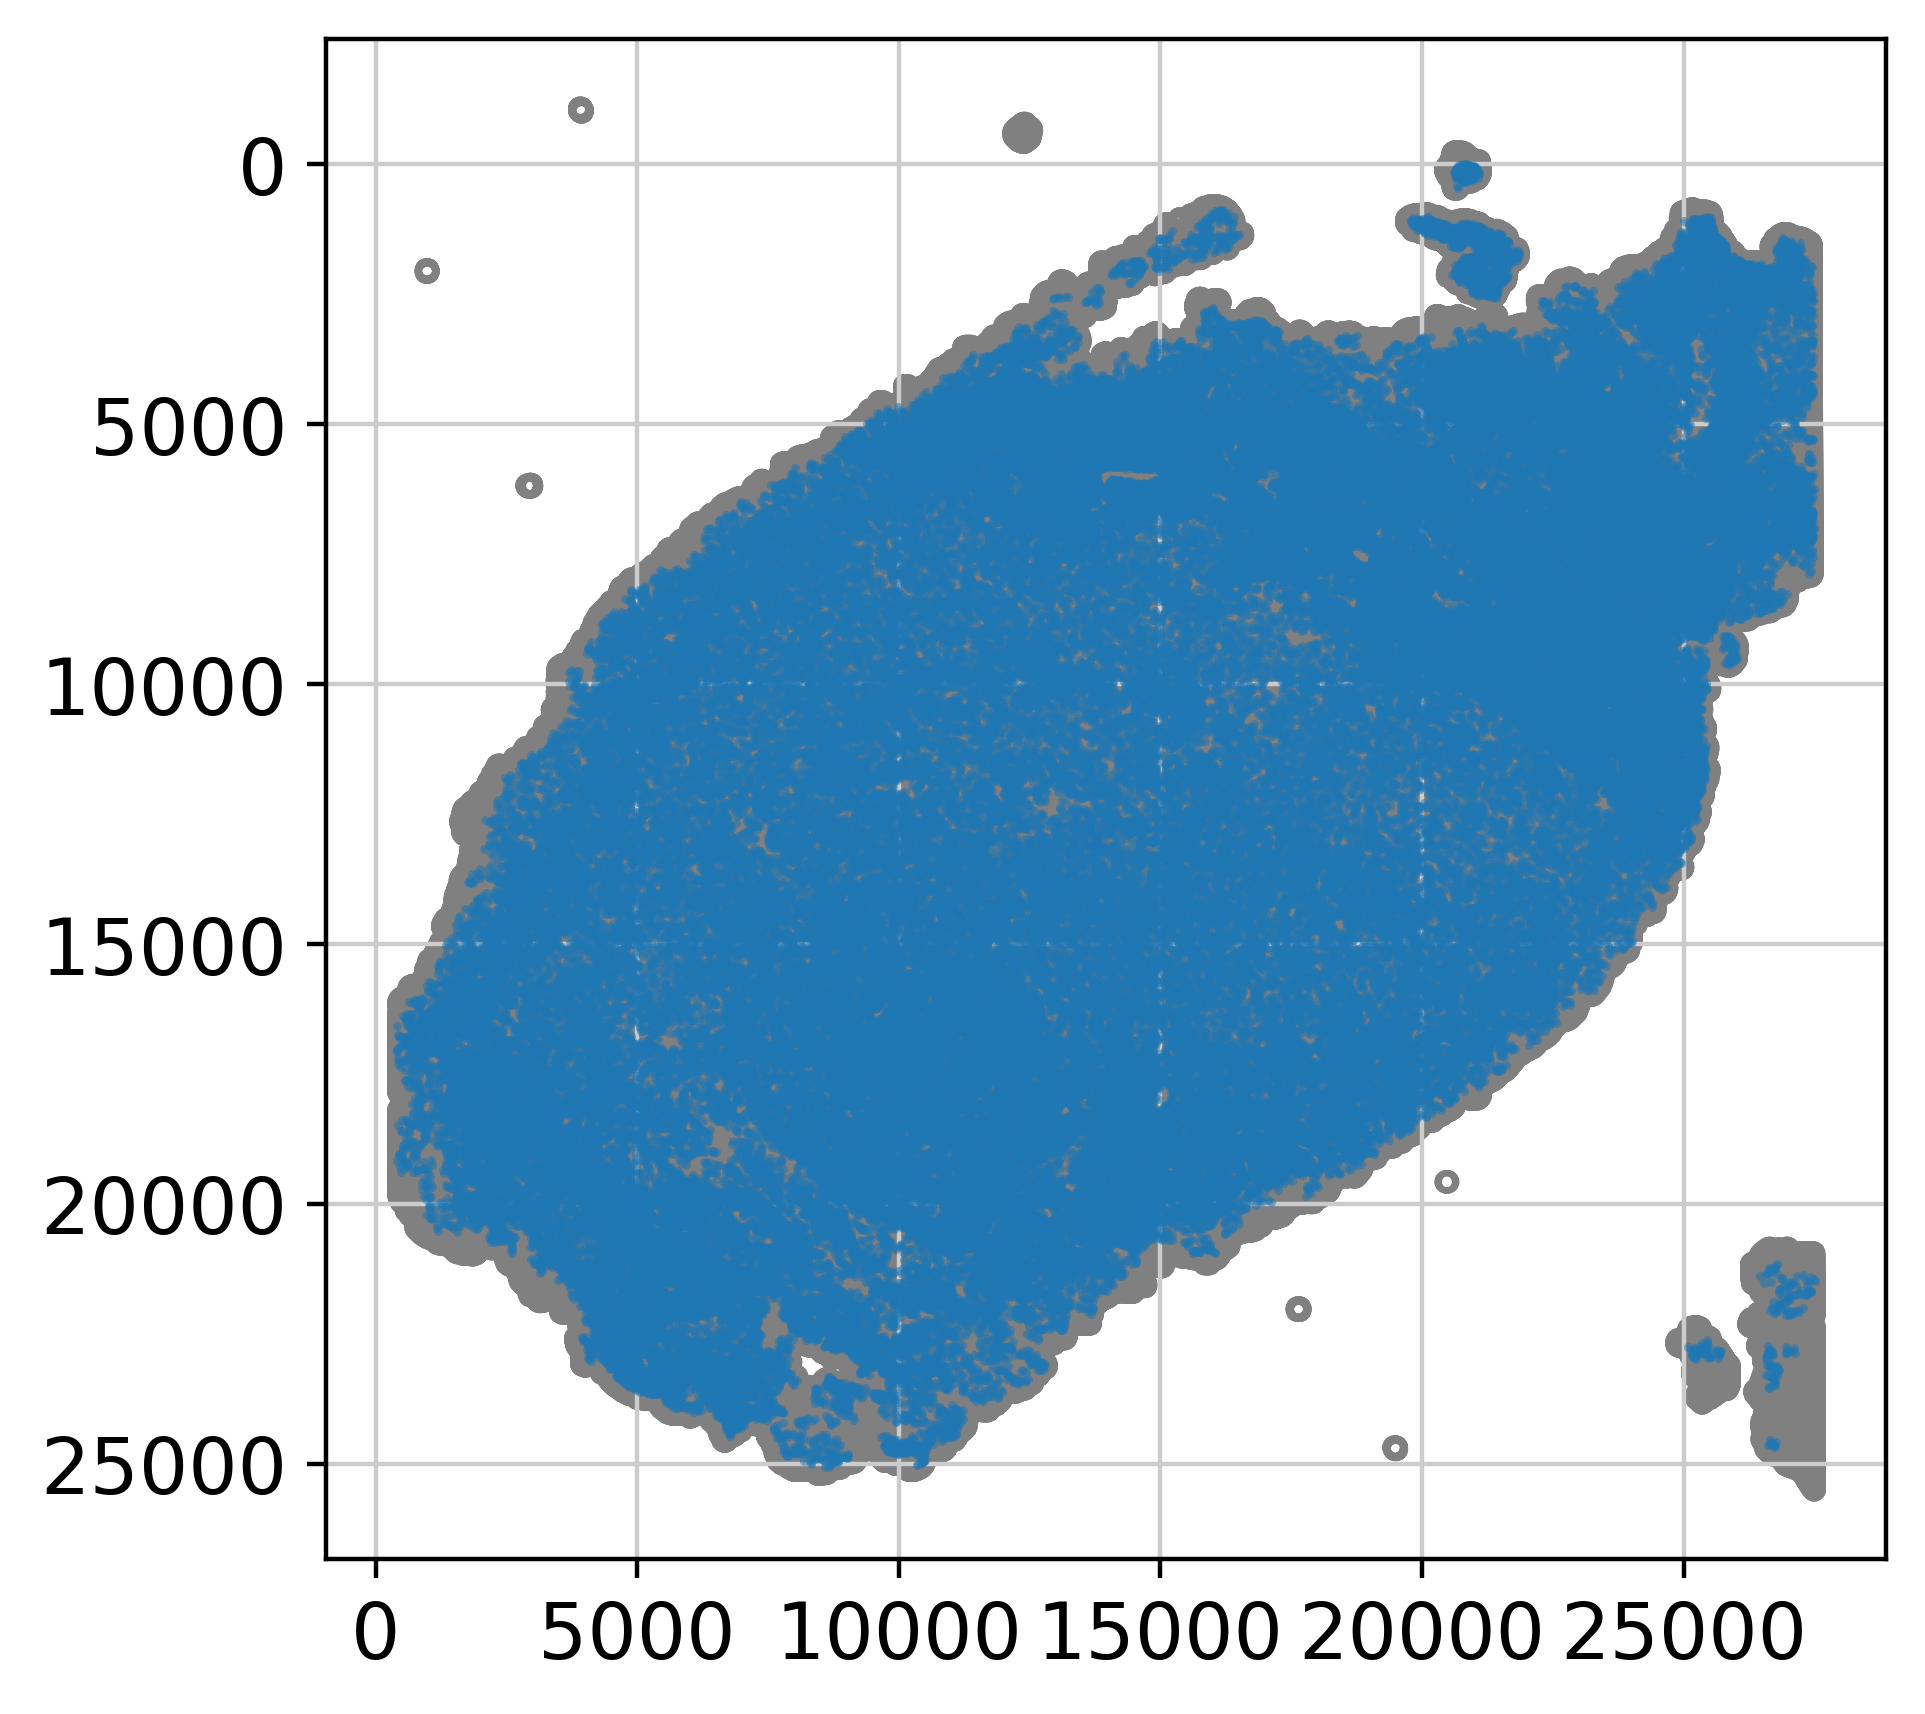

In [8]:
sample = fineST(
    image_path,
    name=name,
    spot_adata_path=spot_adata_path,
    cell_features_csv_path=cell_feature_path
)
sample.prepare_input(mapping_margin=10)

In [10]:
sc.pp.normalize_total(adata_cell, target_sum=10000)
sc.pp.log1p(adata_cell)

In [11]:
sample.adata.X = adata_cell.X
sample.adata.obs_names = adata_cell.obs_names

In [12]:
sc.tl.pca(sample.adata)

### As we already expect that Visium HD data is of high quality, we recommend to build the cell-cell graph using geom, morph, and trans. Here we show the example of the following settings.
We set `adjust_cell_network_by_transcriptome_scale` = 1 and decrease the weight of morphology `geom_morph_ratio` = 1 as well as increase the threshold of KNN neighbors to build SNN `snn_threshold` = 0.5, 

In this example, we use highly variable genes for prediction. If you would like to include genes of your interest, please directly modify the `adata.var.used_for_prediction` column (`True` for prediction) or add a gene list file.

In [13]:
sc.pp.highly_variable_genes(sample.adata)

In [14]:
sample.set_genes_for_prediction(genes_selection_key='highly_variable')

In [54]:
sample.recipe = 'gene'
sample.set_params(
    is_rawCount=False,
    out_prefix="fineST",
    write_freq=5,
    n_iter=5,
    conn_csr_matrix="force",
    smoothing_scale=0.8,
    node_features_obs_list=['spot_heterogeneity'],
    n_neighbors=10,
    snn_threshold=0.5, 
    geom_morph_ratio=1,
    geom_constraint=0,
    inflation_percentage=None,
    regulate_expression_mean=False,
    stochastic_expression_neighbors_level='spot',
    smooth_predicted_expression_steps=0,
    reduced_dimension_transcriptome_obsm_key="X_pca",
    reduced_dimension_transcriptome_obsm_dims=15,
    adjust_cell_network_by_transcriptome_scale=1,
    burn_in_steps=1,
    n_jobs=20)

In [55]:
sample.predict_gene_expression()

[09/02/25 15:04:55] INFO     Thor: Using mode gene                                                                                                    
[09/02/25 15:09:59] INFO     Thor: Forcing to recalculate the connectivities.                                                                         
                    INFO     Thor: Construct SNN with morphological features: ['mean_gray', 'std_gray', 'entropy_img', 'mean_r', 'mean_g', 'mean_b',  
                             'std_r', 'std_g', 'std_b'].                                                                                              
                    INFO     Thor: Incorporate the effect of transcriptome. The dimension of the transcriptome is 15.                                 
[09/02/25 15:10:03] INFO     Thor: Finish constructing SNN                                                                                            
                    INFO     Thor: Add adata.obsp["snn_connectivities"]                       

In [ ]:
ad_thor = sample.load_result('fineST_5.npz')
ad_thor

In [57]:
# save ad_thor
ad_thor.write(f"./{name}/{name}_finesST_5_result_002um.h5ad")

## Compare gene expression profiles between the Thor results with VisiumHD 008μm data (close to the actual cell size).

In [20]:
ad_HD = sc.read_h5ad(f"./{name}/{name}_raw_008um.h5ad")
sc.pp.normalize_total(ad_HD, target_sum=10000)
sc.pp.log1p(ad_HD)

### Thor result (direct mapping of bins to cells)

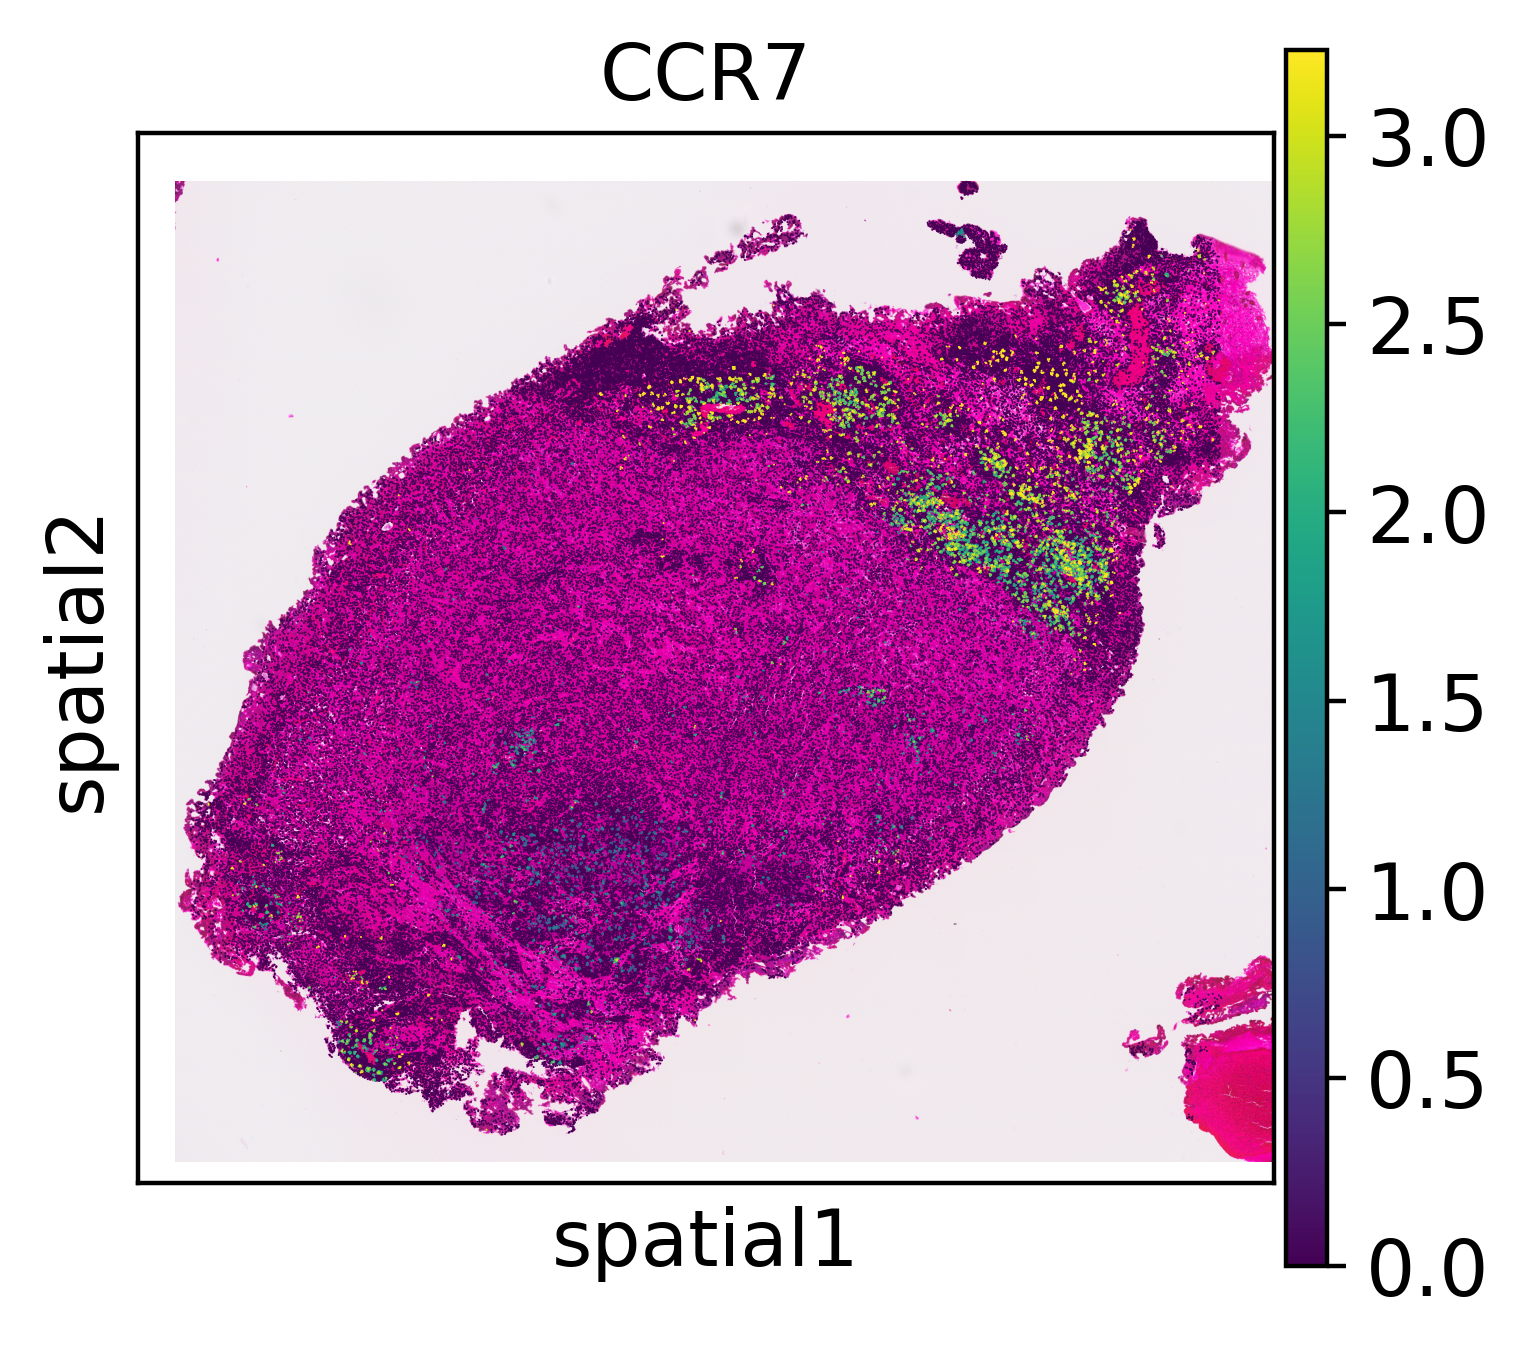

In [64]:
sc.pl.spatial(sample.adata, color="CCR7", spot_size=50, vmax='p99')

### Thor result (diffusion)

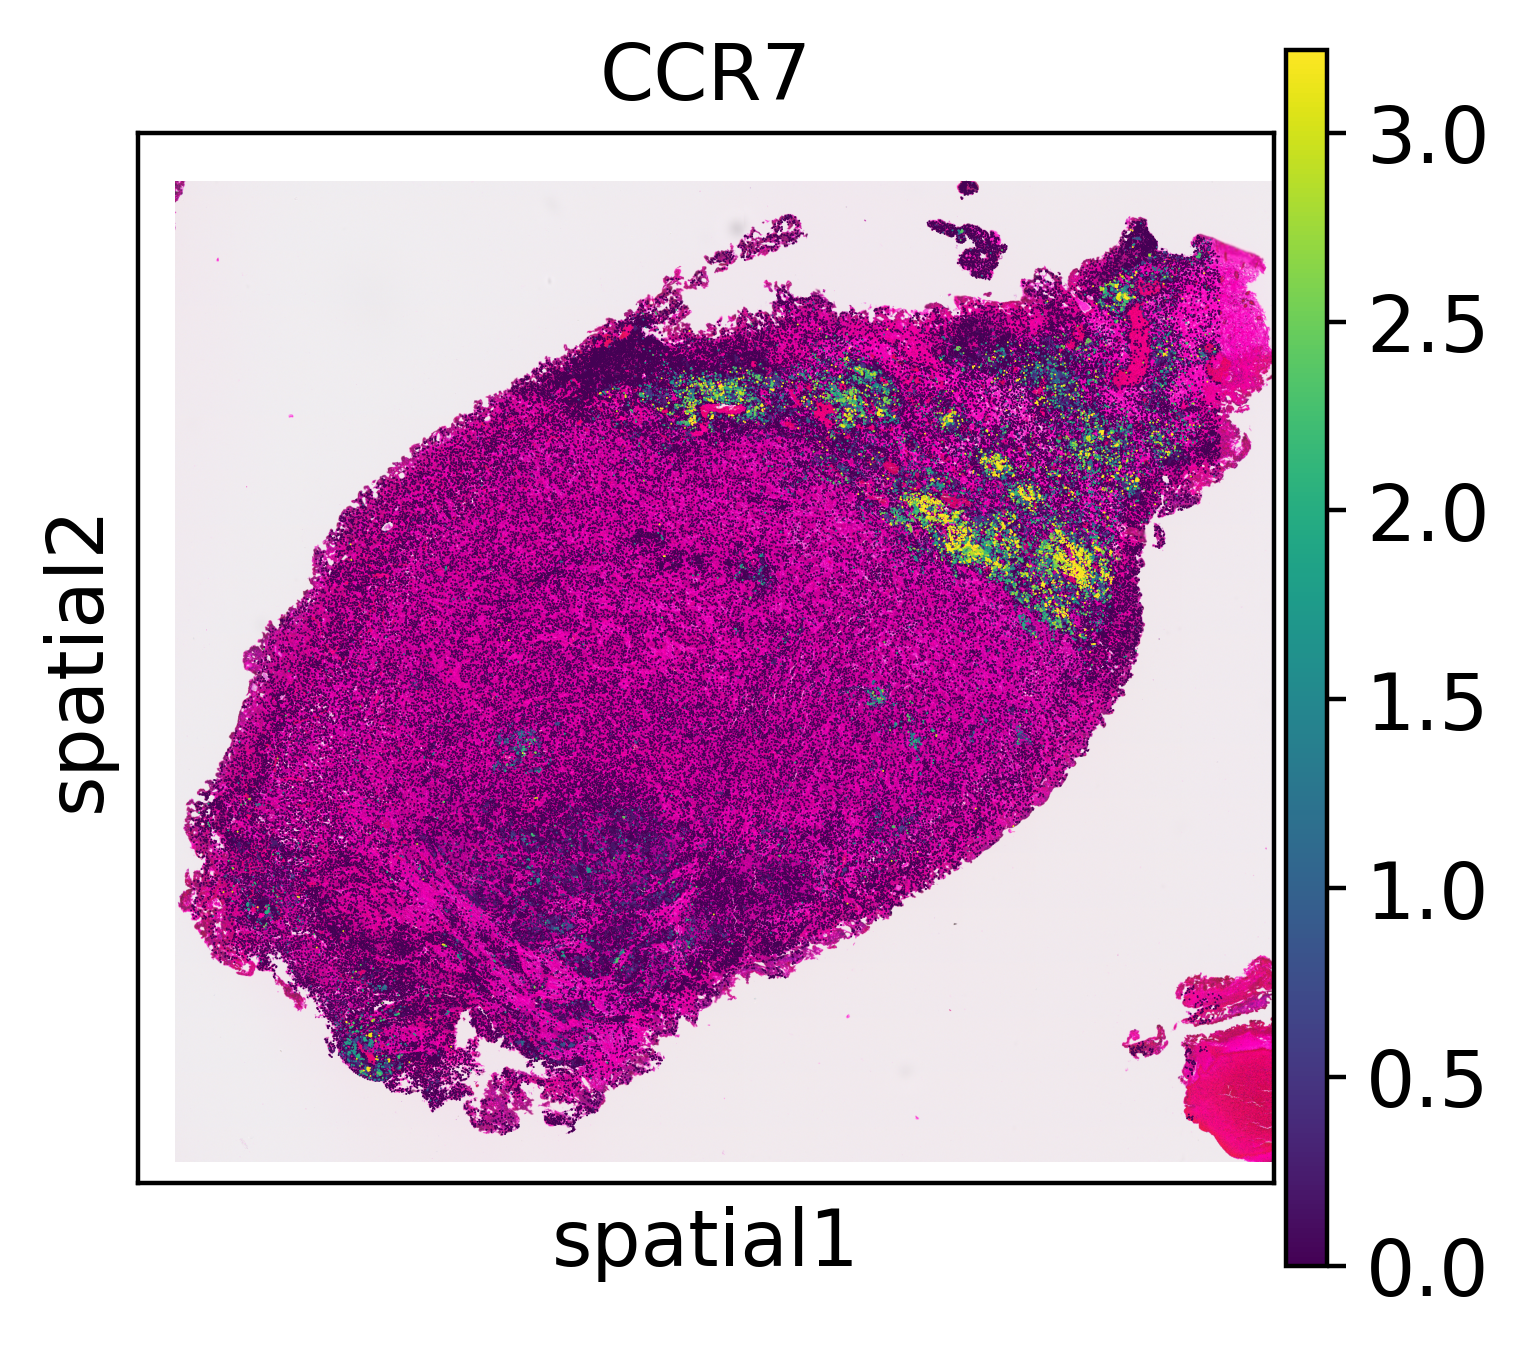

In [62]:
sc.set_figure_params(dpi=200)
sc.pl.spatial(ad_thor, color="CCR7", spot_size=50, vmax='p99')

### Visium HD 8 um bins

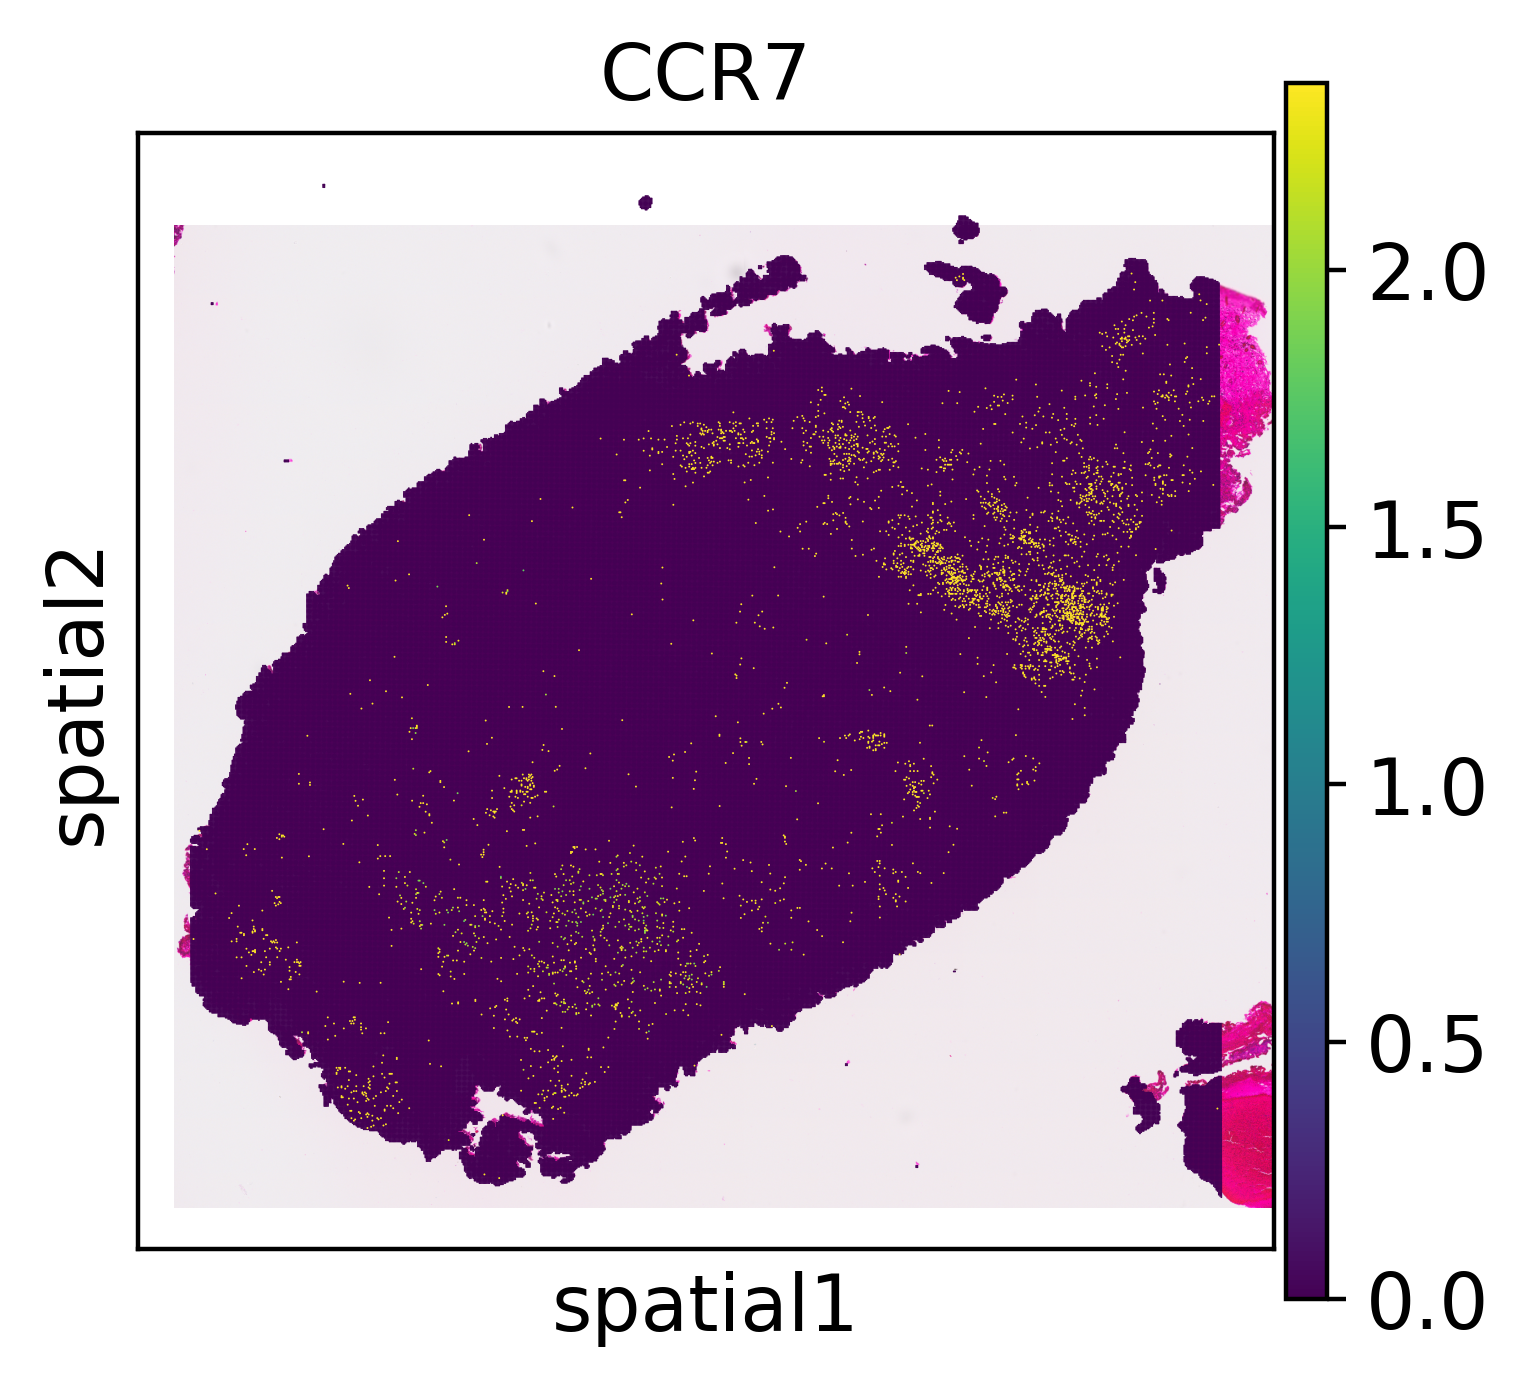

In [65]:
sc.pl.spatial(ad_HD, color="CCR7", spot_size=50, vmax='p99')